<a href="https://colab.research.google.com/github/Lindaagstna/praktikumML04/blob/main/praktikum4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## menghubungkan colab dengan google
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## memanggil data
path ="/content/drive/MyDrive/SEMESTER3/praktikum_ml/praktikum04"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
)

In [ ]:
df = pd.read_csv(path + "/data/stunting_wasting_dataset.csv")
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


In [ ]:
## cek missing value
df.isnull().sum()

,0
Jenis Kelamin,0
Umur (bulan),0
Tinggi Badan (cm),0
Berat Badan (kg),0
Stunting,0
Wasting,0


In [ ]:
df['Stunting'].unique()

array(['Tall', 'Stunted', 'Normal', 'Severely Stunted'], dtype=object)

In [ ]:
df['Jenis Kelamin'].unique()

array(['Laki-laki', 'Perempuan'], dtype=object)

In [ ]:
## 1 mapping kolom stunting biner
map_stunt = {'Stunted': 1,'Severely Stunted': 1, 'Normal': 0, 'Tall': 0}
df['Stunting_bin'] = df["Stunting"].map(map_stunt).astype('Int64')

## 2 mapping kolom jenis kelamim biner
## laki laki = 1, perempuan = 0
df['JK_bin'] = (df["Jenis Kelamin"] == 'Laki-laki').astype(int)

print("Distribusi Stunting_bin:\n", df["Stunting_bin"].value_counts())
print("\nDistribusi JK_bin:\n", df["JK_bin"].value_counts())

Distribusi Stuntint_bin:
 Stunting_bin
0    78021
1    21979
Name: count, dtype: Int64

Distribusi JK_bin:
 JK_bin
1    50179
0    49821
Name: count, dtype: int64


In [ ]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_bin,JK_bin
Umur (bulan),1.000000,0.875869,0.665389,0.038630,0.004046
Tinggi Badan (cm),0.875869,1.000000,0.626005,-0.283855,0.073505
Berat Badan (kg),0.665389,0.626005,1.000000,0.021090,0.045797
Stunting_bin,0.038630,-0.283855,0.021090,1.000000,-0.005981
JK_bin,0.004046,0.073505,0.045797,-0.005981,1.000000


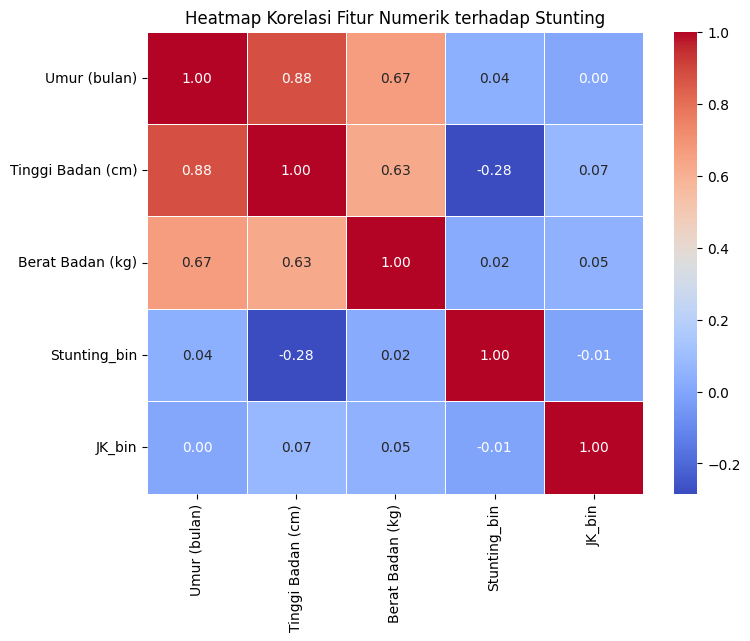

In [ ]:
## Visualisasi heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap Korelasi Fitur Numerik terhadap Stunting', fontsize=12)
plt.show()

In [ ]:
## Fitur numeric dan gender
feature_num = ['Umur (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']
feature_bin = ['JK_bin']

## gabungkan & drop missing
use_cols = feature_num + feature_bin + ['Stunting_bin']
df_model = df[use_cols].dropna().copy()

X = df_model[feature_num + feature_bin]
y = df_model['Stunting_bin']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (100000, 4)
y shape: (100000,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data latih:", X_train.shape)
print("Data uji:", X_test.shape)

Data latih: (80000, 4)
Data uji: (20000, 4)


In [ ]:
## Scale hanya fitur numerik, gender langsung passthrough
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_num),
        ('bin', 'passthrough', feature_bin)
    ],
    remainder='drop'
)

model = LogisticRegression(
    max_iter = 1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([
    ('preprocess', preprocess),
    ('model', model)
])

## latih model
clf.fit(X_train, y_train)
print("Model Logistic Regression berhasil dilatih")

Model Logistic Regression berhasil dilatih


In [ ]:
## prediksi & probabilitas
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

## hitung numerik
print(f"Akurasi: {accuracy_score(y_test, y_pred):.4f}")
print(f"Presisi: {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

Akurasi: 0.9055
Presisi: 0.7152
Recall: 0.9472
F1 Score: 0.8150
ROC AUC Score: 0.9656


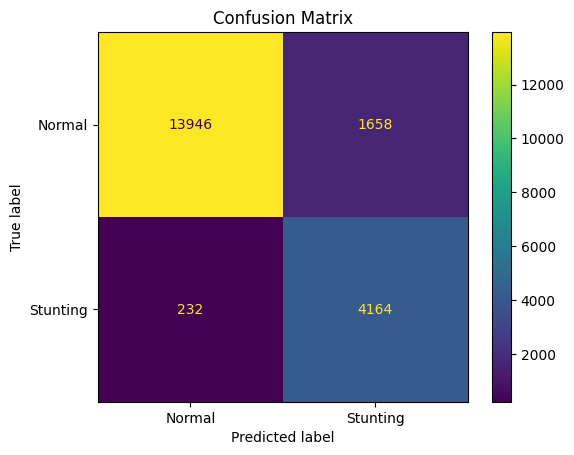

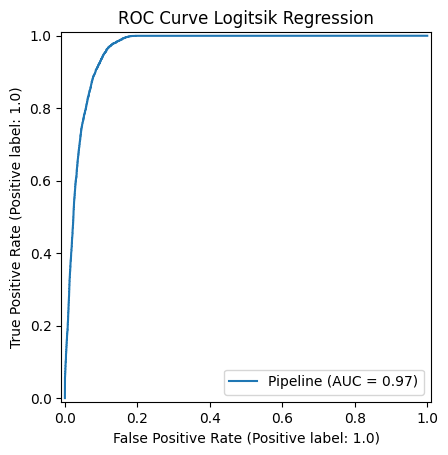

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
                       display_labels=['Normal', 'Stunting']).plot(values_format= 'd')
plt.title('Confusion Matrix')
plt.show()

## ROC Curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title('ROC Curve Logitsik Regression')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Tidak Stunting (0)','Stunting (1)']))

                    precision    recall  f1-score   support

Tidak Stunting (0)       0.98      0.89      0.94     15604
      Stunting (1)       0.72      0.95      0.82      4396

          accuracy                           0.91     20000
         macro avg       0.85      0.92      0.88     20000
      weighted avg       0.92      0.91      0.91     20000



In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=5)

print("Skor tiap fold:", scores)
print("Rata-rata akurasi:", np.mean(scores))
print("Standar deviasi:", np.std(scores))

Skor tiap fold: [0.9062  0.9013  0.9052  0.89905 0.9002 ]
Rata-rata akurasi: 0.9023899999999999
Standar deviasi: 0.0028125433329995106


In [ ]:
## ambil nama fitur & kefesien
feat_names = feature_num + feature_bin
coefs = clf.named_steps['model'].coef_[0]
odds = np.exp(coefs)

coef_df = pd.DataFrame({
    'Fitur': feat_names,
    'Koefisien (log-odds)': coefs,
    'Odds Ratio (e^coef)': odds
}).sort_values('Odds Ratio (e^coef)', ascending=False)

display(coef_df)

,Fitur,Koefisien (log-odds),Odds Ratio (e^coef)
0,Umur (bulan),8.525912,5043.782458
3,JK_bin,1.675944,5.343839
2,Berat Badan (kg),0.661090,1.936903
1,Tinggi Badan (cm),-10.535980,0.000027


In [ ]:
## Contoh 2 anak
df2 = pd.DataFrame({
    'Umur (bulan)': [24, 10],
    'Tinggi Badan (cm)': [79.0, 72.5],
    'Berat Badan (kg)': [9.2, 7.8],
    'JK_bin': [1, 0]
})

pred = clf.predict(df2)
prob = clf.predict_proba(df2)[:,1]

hasil = df2.copy()
hasil['Prob_stunting'] = prob
hasil['Pred (0=Tidak,1=Ya)'] = pred
display(hasil)

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),JK_bin,Prob_stunting,"Pred (0=Tidak,1=Ya)"
0,24,79.0,9.2,1,0.998208,1.0
1,10,72.5,7.8,0,0.002094,0.0
